# Customer Reviews Sentiment Classification Model

This notebook builds and evaluates a machine learning model to classify customer reviews as positive or negative.

**Pipeline Overview:**
1. Load the cleaned dataset from the previous notebook
2. Split data into training and test sets
3. Convert text to numerical features using TF-IDF
4. Train a Logistic Regression classifier
5. Evaluate model performance
6. Analyze feature importance to understand what drives predictions

Let's get started!

In [22]:
import pandas as pd

df = pd.read_csv("../data/clean_reviews.csv")
df.head()


,Text,Sentiment,Clean_Text,length
0,Having tried a couple of other brands of glute...,1,having tried a couple of other brands of glute...,463
1,My cat loves these treats. If ever I can't fin...,1,my cat loves these treats if ever i cant find ...,473
2,A little less than I expected. It tends to ha...,1,a little less than i expected it tends to have...,131
3,"First there was Frosted Mini-Wheats, in origin...",0,first there was frosted miniwheats in original...,1539
4,and I want to congratulate the graphic artist ...,1,and i want to congratulate the graphic artist ...,618


## Load Cleaned Data

We'll load the preprocessed dataset we created in the data cleaning notebook.

**What we expect:**
- `Clean_Text`: Preprocessed review text (lowercase, no punctuation, etc.)
- `Sentiment`: Binary labels (0 = Negative, 1 = Positive)
- No missing values or duplicates

This cleaned data is ready for feature extraction and modeling.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Text'],
    df['Sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment']  # preserves imbalance ratio
)

## Split Data into Train and Test Sets

We'll divide our data into training and testing subsets to evaluate model performance on unseen data.

**Split configuration:**
- **80% training** - Used to train the model
- **20% testing** - Used to evaluate model performance
- **Stratified split** - Maintains the same class ratio in both sets (important with imbalanced data)
- **Random seed = 42** - Ensures reproducibility

This prevents the model from simply memorizing the training data and helps us assess how well it generalizes.

## Convert Text to Numbers (TF-IDF Vectorization)

Machine learning models require numerical input, so we'll convert text reviews into numerical feature vectors using **TF-IDF** (Term Frequency-Inverse Document Frequency).

**TF-IDF parameters:**
- `max_features=10000` - Limit vocabulary to top 10,000 most important words (reduces dimensionality)
- `ngram_range=(1,2)` - Include both single words (unigrams) and two-word phrases (bigrams)
  - Example: "not good" as a bigram captures negation better than separate words
- `stop_words='english'` - Remove common words like "the", "is", "and" that don't carry sentiment

**How TF-IDF works:**
- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: Reduces weight of words that appear in many documents
- Result: Important, distinctive words get higher weights

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,  # cap vocab size
    ngram_range=(1,2),   # include bigrams
    stop_words='english' # remove common words
    )

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Train the Classification Model

We'll use **Logistic Regression**, a simple yet effective algorithm for binary classification.

**Why Logistic Regression?**
- Fast to train and predict
- Interpretable - we can see which words influence predictions
- Works well with high-dimensional sparse data (like TF-IDF vectors)
- Provides probability scores for predictions

**Handling class imbalance:**
- `class_weight='balanced'` - Automatically adjusts weights to compensate for imbalanced classes
- `sample_weight` - Further emphasizes the minority class during training
- This helps the model learn to recognize negative reviews despite having fewer examples

**Training parameters:**
- `max_iter=1000` - Maximum number of iterations for the optimization algorithm

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import compute_class_weight
import numpy as np

classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_to_w = {c: w for c, w in zip(classes, weights)}
sample_weight = y_train.map(class_to_w).values

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train, sample_weight=sample_weight)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluate Model Performance

Now let's assess how well our model performs on the test set (data it has never seen before).

**Evaluation metrics:**
- **Precision**: Of all reviews predicted as positive/negative, what percentage were correct?
- **Recall**: Of all actual positive/negative reviews, what percentage did we identify?
- **F1-Score**: Harmonic mean of precision and recall (balances both metrics)
- **Confusion Matrix**: Visual breakdown of true positives, true negatives, false positives, and false negatives

These metrics help us understand not just accuracy, but how the model performs on each class separately.

              precision    recall  f1-score   support

           0      0.534     0.795     0.639      1297
           1      0.963     0.886     0.923      7875

    accuracy                          0.873      9172
   macro avg      0.749     0.840     0.781      9172
weighted avg      0.903     0.873     0.883      9172



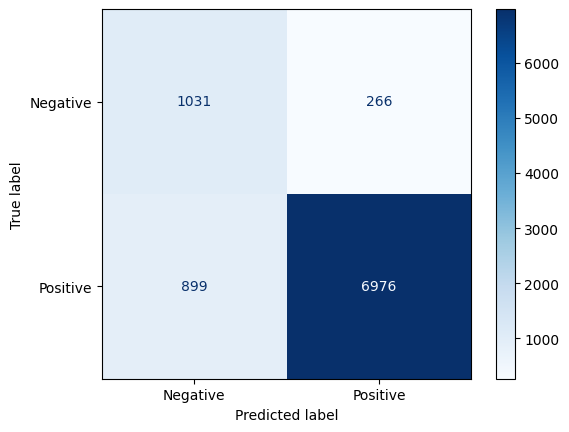

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')


## Feature Importance Analysis

Let's examine which words have the strongest influence on sentiment predictions.

**How it works:**
- Logistic Regression assigns a coefficient to each feature (word/phrase)
- **Positive coefficients** → words that indicate positive sentiment
- **Negative coefficients** → words that indicate negative sentiment
- Larger absolute values = stronger influence on prediction

**Why this matters:**
- Validates that the model learned meaningful patterns
- Helps identify potential bias or unexpected associations
- Provides transparency into model decision-making
- Can reveal data quality issues

In [27]:
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]
top_pos = sorted(zip(coefs, feature_names), reverse=True)[:20]
top_neg = sorted(zip(coefs, feature_names))[:20]

print("🟢 Positive words:")
for coef, word in top_pos[:10]:
    print(f"{word}: {coef:.3f}")

print("\n🔴 Negative words:")
for coef, word in top_neg[:10]:
    print(f"{word}: {coef:.3f}")


🟢 Positive words:
great: 9.896
delicious: 7.939
perfect: 7.048
best: 7.048
love: 6.774
excellent: 5.958
loves: 5.511
nice: 5.337
wonderful: 5.197
highly: 5.090

🔴 Negative words:
disappointed: -6.507
horrible: -5.788
terrible: -5.495
worst: -5.481
disappointing: -5.350
weak: -5.228
awful: -5.161
thought: -4.666
unfortunately: -4.291
nasty: -4.246


## Model Performance Summary

**Key observations:**

Looking at the evaluation metrics above, we can assess:

1. **Overall Accuracy** - The percentage of correct predictions
2. **Class-specific Performance** - How well the model performs on positive vs. negative reviews
3. **Confusion Matrix** - Where the model makes mistakes

**Handling class imbalance:**
- Our dataset has more positive reviews than negative ones
- We've used `class_weight='balanced'` and sample weights to mitigate this
- Check if the model performs reasonably well on both classes